<a href="https://www.kaggle.com/code/raviiloveyou/dnn-ensembe-methods?scriptVersionId=154892014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
dire = '/kaggle/temp'
if not os.path.exists(dire):
    os.makedirs(dire)
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [2]:
import re
import os
import random
#from collections import Counter,defaultdict
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import time
import matplotlib.pyplot as plt
import seaborn as sns
#from tqdm.notebook import tqdm
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder,PowerTransformer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble  import GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error
#import lightgbm as lgb
from scipy.stats import skew, kurtosis
from scipy import stats

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
train_scores=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
test_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")


In [4]:
print(train_scores.head(),"\n")
print(train_scores.isnull(),"\n")
print(train_logs.head(),"\n")
print(train_logs.isnull(),"\n")
print(train_logs.describe())
print(train_scores.dropna)
print(train_logs.dropna)
print(test_logs.dropna())

         id  score
0  001519c8    3.5
1  0022f953    3.5
2  0042269b    6.0
3  0059420b    2.0
4  0075873a    4.0 

         id  score
0     False  False
1     False  False
2     False  False
3     False  False
4     False  False
...     ...    ...
2466  False  False
2467  False  False
2468  False  False
2469  False  False
2470  False  False

[2471 rows x 2 columns] 

         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0    

In [5]:
print(train_scores["score"].head())
print("Max:",train_scores["score"].max(),"  Min:" , train_scores["score"].min())

0    3.5
1    3.5
2    6.0
3    2.0
4    4.0
Name: score, dtype: float64
Max: 6.0   Min: 0.5


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

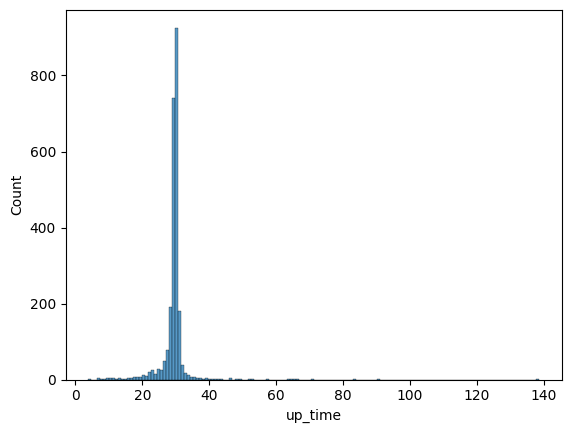

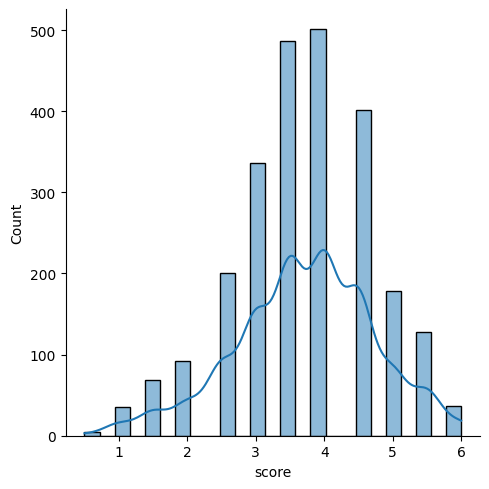

In [6]:
time=train_logs[["id","up_time"]].groupby("id").max()
time["up_time"]=time["up_time"]/1000/60
sns.histplot(time["up_time"],bins=150)

#scores distribution or frequency
sns.displot(train_scores["score"],kde=True)



In [7]:
print(train_logs["activity"].unique())

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

In [8]:
print(train_logs["activity"].str[:4].unique())
print(train_logs["up_event"].unique(),"\n")


['Nonp' 'Inpu' 'Remo' 'Repl' 'Move' 'Past']
['Leftclick' 'Shift' 'q' 'Space' 'Backspace' '.' ',' 'Enter' 'ArrowLeft'
 "'" ';' 'ArrowRight' '-' '?' 'Tab' '"' 'ArrowUp' 'ArrowDown' 'm'
 'Rightclick' 'i' 'o' 't' '=' 'a' 'CapsLock' 'Control' 'c' 'v' '/'
 'Delete' ':' 'z' '[' '$' '(' ')' '+' 'Home' 'End' '\\' 'Meta' '*' '&'
 'AudioVolumeMute' 'x' '!' 'Insert' 'MediaPlayPause' 'w' 'NumLock' '%' 'V'
 'b' '>' 'Alt' 'AudioVolumeUp' 'ContextMenu' 'AudioVolumeDown' 'n' 'e' '<'
 'PageDown' ']' 'Middleclick' '@' 'F12' 'u' 'j' 's' '\x96' 'Dead' 'y' '{'
 'ScrollLock' '¿' 'p' 'Process' '}' 'MediaTrackPrevious' 'MediaTrackNext'
 'F3' '^' 'Unidentified' 'Cancel' 'h' '2' 'd' 'r' '`' '\x9b' 'f' 'g' '#'
 '~' 'PageUp' 'l' 'T' 'A' 'S' 'ModeChange' '_' 'Escape' 'F11'
 'Unknownclick' 'AltGraph' 'F10' 'F15' 'Clear' 'OS' 'C' 'Ä±' 'M' '|'
 'â\x80\x93' '0' '1' '5' '\x97' 'Ë\x86' '¡' '\x80' 'Â´' 'Å\x9f' 'F2' 'ä'
 'F1' 'k' 'Pause' 'F6'] 



In [9]:
from tqdm import tqdm
def feature_extraction(data):
    
    data["time_interval"]=data.groupby("id")["action_time"].diff()
    data["event_rate"]=1/data["time_interval"]
    
    data["event_duration_variation"]=data.groupby("id")["action_time"].transform("std")
    data['event_sequence_change'] = (data['down_event'] != data['down_event'].shift(1)).astype(int)

    # Calculate 'total_characters' as the cumulative sum of non-Backspace events
    data['total_characters'] = (data['down_event'] != 'Backspace').groupby(data['id']).cumsum()

    data["event_transition_count"]=data.groupby(["id","down_event","up_event"]).cumcount()+1
    data['total_characters'] = data['total_characters'].replace(0, np.nan)
    data['down_event_numeric'] = pd.factorize(data['down_event'])[0]

# Calculate 'unique_events_count' by dividing the number of unique events by 'total_characters'
    data["unique_events_count"] = data.groupby("id")["down_event_numeric"].transform('nunique') / data["total_characters"]

    
    # Text change features
    data['text_change_frequency'] = data.groupby('id')['text_change'].transform('sum')
    #data['text_change_ratio'] = data['text_change_frequency'] / data['total_characters'].replace(0, np.nan)
    data['text_change_frequency'] = pd.to_numeric(data['text_change_frequency'], errors='coerce')

# Convert 'total_characters' to numeric type (assuming it's currently a string)
    data['total_characters'] = pd.to_numeric(data['total_characters'], errors='coerce')

# Replace NaN values with 0 in 'total_characters' (or any other default value you prefer)
    data['total_characters'] = data['total_characters'].fillna(0)

# Avoid division by zero by replacing 0 in 'total_characters' with NaN
    data['total_characters'] = data['total_characters'].replace(0, np.nan)

# Perform division
    data['text_change_ratio'] = data['text_change_frequency'] / data['total_characters']

    data["activity_duration"]=data.groupby(["id","activity",])["action_time"].transform('sum')
    data["activity_transition_count"]=data.groupby("id")["word_count"].transform("nunique")
    
    data["cursor_postion"]=data["cursor_position"]/data["total_characters"].replace(0,np.nan)
    data["word_count_change_rate"]=data.groupby("id")["word_count"].transform("diff")/data["time_interval"]
    
    
    data["word_count_trend"]=data.groupby("id")["word_count"].transform("diff").rolling(window=3).mean()
    
    
    data["event_duration_diff"]=data.groupby("id")["action_time"].transform("diff")
    
    
    tqdm.pandas(desc="Processing 'id'")
    data_grouped=data.groupby('id').progress_apply(lambda x:x)
    
    final_data = data.groupby('id').agg({
        'event_rate': 'mean',
        'event_duration_variation': 'mean',
        'event_sequence_change': 'mean',
        'event_transition_count': 'last',
        'unique_events_count': 'last',
        'text_change_ratio': 'mean',
        'activity_duration': 'mean',
        'activity_transition_count': 'last',
        'cursor_position': 'mean',
        'word_count_change_rate': 'mean',
        'event_duration_diff': 'mean',
        #'score': 'last' 
    }).reset_index()

    return final_data

#tqdm.pandas(desc="Processing 'id'")
#data_grouped = data.groupby('id').progress_apply(lambda x: x)


path="/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
data=pd.read_csv(path)
features=feature_extraction(data)
directory_path = '/kaggle/temp'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
file_path=os.path.join(directory_path,'trimmed_features.csv')
features.to_csv(file_path, index=False)
print(f"Features saved to temporary file: {file_path}")

Processing 'id': 100%|██████████| 2471/2471 [00:06<00:00, 379.98it/s] 


Features saved to temporary file: /kaggle/temp/trimmed_features.csv


In [10]:
new_data=pd.read_csv("/kaggle/temp/trimmed_features.csv")
#new_data.head()
#new_data = new_data.drop(["event_rate", "text_change_ratio", "word_count_change_rate"], axis=1)
new_data.head()

,id,event_rate,event_duration_variation,event_sequence_change,event_transition_count,unique_events_count,text_change_ratio,activity_duration,activity_transition_count,cursor_position,word_count_change_rate,event_duration_diff
0,001519c8,inf,91.797374,0.355495,92,0.005607,NaN,198028.303481,257,711.163473,NaN,0.023865
1,0022f953,inf,55.431189,0.410758,3,0.007748,NaN,191791.483700,324,776.205786,NaN,-0.041989
2,0042269b,inf,82.383766,0.343085,129,0.003516,NaN,305539.139023,405,731.611702,NaN,0.084885
3,0059420b,inf,113.768226,0.409383,13,0.010684,NaN,142597.392031,207,542.537275,NaN,-0.027653
4,0075873a,inf,62.082013,0.349269,10,0.005462,NaN,212903.259186,253,600.050968,NaN,-0.055731


In [11]:
new_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with NaN or inf values
new_data = new_data.dropna(axis=1, how='any')

# Display columns with NaN values (if any)


In [12]:
param_grid_hist={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4,3,9]
}

param_grid_gb={
    'learning_rate': [0.01, 0.1, 0.2,0.001],
    'n_estimators': [60, 100, 200,250],
    'max_depth': [3, 5, 7,10,11,9,4,2,13,20],
    'min_samples_leaf': [1, 2, 4,3,9,5,7,6,4,10,20]
}

In [13]:
final_df=new_data.merge(train_scores,on="id")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
x=final_df.drop(["id","score"],axis=1)
y=final_df["score"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [15]:
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train)
x_val_imputed = imputer.transform(x_test)

In [16]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_val_scaled = scaler.transform(x_val_imputed)

In [17]:
param_grid_hist={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4,3,9]
}

param_grid_gb={
    'learning_rate': [0.01, 0.1, 0.2,0.001],
    'n_estimators': [60, 100, 200,250],
    'max_depth': [3, 5, 7,10,11,9,4,2,13,20],
    'min_samples_leaf': [1, 2, 4,3,9,5,7,6,4,10,20]
}
param_grid_adaboost = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.001]
}


In [18]:

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
hgbr=HistGradientBoostingRegressor()
gbr=GradientBoostingRegressor()
adaboost_model = AdaBoostRegressor()

In [19]:
kf=KFold(n_splits=3,shuffle=True,random_state=42)
grid_search_hist = GridSearchCV(estimator=hgbr, param_grid=param_grid_hist, scoring='neg_mean_squared_error', cv=kf)
grid_search_gb = GridSearchCV(estimator=gbr, param_grid=param_grid_gb, scoring='neg_mean_squared_error', cv=kf)

In [20]:
grid_search_hist.fit(x_train_scaled,y_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'min_samples_leaf': [1, 2, 4, 3, 9]},
             scoring='neg_mean_squared_error')

In [21]:
print(f" Best Hyperparameters for HistogramGradientBoostingRegressor: {grid_search_hist.best_params_}")

 Best Hyperparameters for HistogramGradientBoostingRegressor: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 9}


In [22]:
y_pred = grid_search_hist.predict(x_val_scaled)


In [23]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Validation RMSE:", rmse)

Validation RMSE: 0.6962044624262034


In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Flatten
def base_nn():
    model=Sequential()
    model.add(Dense(150,input_dim=x_train_scaled.shape[1],activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(150,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(123,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="linear"))
    model.compile(loss="mean_squared_error",optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return model

In [25]:
model=base_nn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               1350      
                                                                 
 batch_normalization (Batch  (None, 150)               600       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               22650     
                                                                 
 batch_normalization_1 (Bat  (None, 150)               600       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               1

In [26]:
model.fit(x_train_scaled,y_train,epochs=50,batch_size=32,validation_data=(x_val_scaled,y_test),verbose=1)

Epoch 1/50
62/62 [==============================] - 8s 9ms/step - loss: 2.2902 - val_loss: 6.3511
Epoch 2/50
62/62 [==============================] - 0s 6ms/step - loss: 1.3771 - val_loss: 2.6859
Epoch 3/50
62/62 [==============================] - 0s 6ms/step - loss: 1.2774 - val_loss: 1.8334
Epoch 4/50
62/62 [==============================] - 0s 6ms/step - loss: 1.1607 - val_loss: 1.0609
Epoch 5/50
62/62 [==============================] - 0s 6ms/step - loss: 1.0633 - val_loss: 0.9114
Epoch 6/50
62/62 [==============================] - 0s 6ms/step - loss: 1.0102 - val_loss: 0.7558
Epoch 7/50
62/62 [==============================] - 0s 6ms/step - loss: 0.9836 - val_loss: 0.8999
Epoch 8/50
62/62 [==============================] - 0s 6ms/step - loss: 0.9576 - val_loss: 0.8995
Epoch 9/50
62/62 [==============================] - 0s 6ms/step - loss: 0.9144 - val_loss: 0.8930
Epoch 10/50
62/62 [==============================] - 0s 6ms/step - loss: 0.9046 - val_loss: 0.8562
Epoch 11/50
62/62 [

In [27]:
pred=model.predict(x_val_scaled)

16/16 [==============================] - 0s 2ms/step


In [28]:
print(f"Root mean squared error when training with neural network:{np.sqrt(mean_squared_error(y_test,pred))}")

Root mean squared error when training with neural network:0.7789629647326


In [29]:
def bottleneck():
    model=Sequential()
    model.add(Dense(150,input_dim=x_train_scaled.shape[1],activation="relu",kernel_initializer=tf.keras.initializers.HeNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(150,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(123,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="linear"))
    model.compile(loss="mean_squared_error",optimizer=tf.optimizers.Adam(learning_rate=0.01))
    return model

In [30]:
inverted_adaboost=bottleneck()

In [31]:
num_boost_rounds = 10
base_estimators = [
    DecisionTreeRegressor(max_depth=2),
    ElasticNet(),
    SVR(kernel='rbf'),
    RandomForestRegressor(max_depth=15, n_estimators=100),
    KNeighborsRegressor(n_neighbors=9)
]

In [32]:
for base_estimator in base_estimators:
    # Create AdaBoostRegressor with the specified base estimator
    ada_boost_model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=10, random_state=42)
    
    # Fit the model
    ada_boost_model.fit(x_train_scaled, y_train)
    

In [33]:
for boost_round in range(num_boost_rounds):
    # Assign weights to samples based on the current neural network's predictions
    sample_weights = np.abs(ada_boost_model.estimators_[boost_round].predict(x_train_scaled)-y_train) +1
    # Train the neural network with the weighted samples
    inverted_adaboost.fit(x_train_scaled, y_train, sample_weight=sample_weights, epochs=50, verbose=0)
    # Evaluate the neural network on the test set
    test_loss = inverted_adaboost.evaluate(x_val_scaled, y_test, verbose=0)
    print(f"Boosting Round {boost_round + 1}, Test Loss: {test_loss}")

Boosting Round 1, Test Loss: 0.5257745385169983
Boosting Round 2, Test Loss: 0.5643348097801208
Boosting Round 3, Test Loss: 0.5391027927398682
Boosting Round 4, Test Loss: 0.5824277997016907
Boosting Round 5, Test Loss: 0.5661945939064026
Boosting Round 6, Test Loss: 0.602308988571167
Boosting Round 7, Test Loss: 0.5861155390739441
Boosting Round 8, Test Loss: 0.610776424407959
Boosting Round 9, Test Loss: 0.5542837381362915
Boosting Round 10, Test Loss: 0.5152880549430847


In [34]:
# Evaluate the neural network on the test set
test_loss = inverted_adaboost.evaluate(x_val_scaled, y_test, verbose=0)
print(f"Boosting Round {boost_round + 1}, VAL Loss: {test_loss}")

Boosting Round 10, VAL Loss: 0.5152880549430847


In [35]:
final_test_loss = inverted_adaboost.evaluate(x_val_scaled, y_test)
print(f"Final Test Loss: {final_test_loss}")

16/16 [==============================] - 0s 2ms/step - loss: 0.5153
Final Test Loss: 0.5152880549430847


In [36]:
ada_pred=inverted_adaboost.predict(x_val_scaled)

16/16 [==============================] - 0s 2ms/step


In [37]:
test_losses=[]
test_losses.append(test_loss)
min_test_loss = float('inf')

In [38]:
avg_test_loss = np.mean(test_losses)

    # Update the best estimator if the current one has a lower test loss
if avg_test_loss < min_test_loss:
    min_test_loss = avg_test_loss
    best_estimator = base_estimator

# Final evaluation on the test set using the best estimator
final_test_loss = inverted_adaboost.evaluate(x_val_scaled, y_test)
print(f"Final Test Loss using the Best Estimator: {final_test_loss}")
print(f"Best Estimator: {best_estimator.__class__.__name__}")

16/16 [==============================] - 0s 2ms/step - loss: 0.5153
Final Test Loss using the Best Estimator: 0.5152880549430847
Best Estimator: KNeighborsRegressor


In [39]:
final_test_loss = mean_squared_error(y_test, ada_pred)
rmse = np.sqrt(final_test_loss)

print(f"Final RMSE using the Best Estimator: {rmse}")
print(f"Best Estimator: {best_estimator.__class__.__name__}")


Final RMSE using the Best Estimator: 0.7178356799717297
Best Estimator: KNeighborsRegressor


In [40]:
test_features=feature_extraction(test_logs)

Processing 'id': 100%|██████████| 3/3 [00:00<00:00, 630.82it/s]


In [41]:
test_features.isnull().sum()

id                           0
event_rate                   0
event_duration_variation     0
event_sequence_change        0
event_transition_count       0
unique_events_count          0
text_change_ratio            3
activity_duration            0
activity_transition_count    0
cursor_position              0
word_count_change_rate       0
event_duration_diff          0
dtype: int64

In [42]:
test_features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [43]:
test_features = test_features.dropna(axis=1, how='any')

In [44]:
X_test=test_features.drop("id",axis=1)

In [45]:
common_features=set(x_train.columns) & set(X_test.columns)

In [46]:
common_features=list(common_features)
X_test_common=X_test[common_features]
X_test_common = X_test_common[x_train.columns]
X_test_imputed=imputer.transform(X_test_common)

In [47]:
X_test_common.dropna(axis=1, how='any')

,event_duration_variation,event_sequence_change,event_transition_count,unique_events_count,activity_duration,activity_transition_count,cursor_position,event_duration_diff
0,1.414214,0.5,2,0.5,172.0,1,0.5,2.0
1,14.849242,0.5,2,0.5,113.0,1,0.5,-21.0
2,26.870058,1.0,1,1.0,150.0,2,0.5,-38.0


In [48]:
X_test_scaler=scaler.transform(X_test_imputed)

In [49]:
test_predictions=inverted_adaboost.predict(X_test_scaler)

1/1 [==============================] - 0s 20ms/step


In [50]:
# Flatten nested lists and ensure that the length matches the number of unique IDs
test_predictions_flat = [item for sublist in test_predictions for item in sublist]
test_predictions_flat = test_predictions_flat[:len(test_logs["id"])]

# Create the DataFrame with flattened predictions
# Replace NaN values with a default value (e.g., 0.0)
test_predictions_flat_no_nan = [score if not np.isnan(score) else 0.0 for score in test_predictions_flat]

# Round predicted scores to the nearest half
rounded_predictions = [round(score * 2) / 2 for score in test_predictions_flat_no_nan]

# Use zip and pd.Series to create the DataFrame
result_df = pd.DataFrame({"id": test_logs["id"], "predicted_score": pd.Series(rounded_predictions)})

# Save the predictions to a CSV file
result_df.to_csv("/kaggle/working/predictions.csv", index=False)


In [51]:
result_df.head()

,id,predicted_score
0,0000aaaa,-19.0
1,0000aaaa,-30.5
2,2222bbbb,-62.5
3,2222bbbb,NaN
4,4444cccc,NaN
